In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4090


In [2]:
import os
import xml.etree.ElementTree as ET

# 클래스 정의
CLASSES = [
    'BackgroundImage', 'Bottom_Navigation', 'Card', 'CheckBox', 'Checkbox',
    'CheckedTextView', 'Drawer', 'EditText', 'Icon', 'Image', 'Map', 'Modal',
    'Multi_Tab', 'PageIndicator', 'Remember', 'Spinner', 'Switch', 'Text',
    'TextButton', 'Toolbar', 'UpperTaskBar', 'Button'  # 버튼이 포함돼 있어야 탐지 가능
]

# 좌표 변환 함수
def convert_box(size, box):
    dw, dh = 1./size[0], 1./size[1]
    x = (box[0]+box[1])/2.0
    y = (box[2]+box[3])/2.0
    w = box[1]-box[0]
    h = box[3]-box[2]
    return (x*dw, y*dh, w*dw, h*dh)

# VOC → YOLO 변환 함수
def convert_voc_to_yolo(xml_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for xml_file in os.listdir(xml_folder):
        if not xml_file.endswith(".xml"):
            continue

        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()

        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        file_id = os.path.splitext(xml_file)[0]
        output_path = os.path.join(output_folder, f"{file_id}.txt")

        with open(output_path, "w") as out_file:
            for obj in root.iter("object"):
                cls = obj.find("name").text
                if cls not in CLASSES:
                    continue
                cls_id = CLASSES.index(cls)

                xmlbox = obj.find("bndbox")
                b = (
                    float(xmlbox.find("xmin").text),
                    float(xmlbox.find("xmax").text),
                    float(xmlbox.find("ymin").text),
                    float(xmlbox.find("ymax").text)
                )
                bb = convert_box((w, h), b)
                out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")


In [3]:
convert_voc_to_yolo("All Dataset 2/Android/Annotations", "labels_all")
convert_voc_to_yolo("All Dataset 2/iphone/Annotations", "labels_all")
convert_voc_to_yolo("All Dataset 2/Rico/Annotations", "labels_all")
convert_voc_to_yolo("All Dataset 2/uplabs/Annotations", "labels_all")
convert_voc_to_yolo("All Dataset 2/Wireframes/Annotations", "labels_all")


In [4]:
import shutil
import random

def split_dataset(img_src, label_src, train_ratio=0.8):
    imgs = [f for f in os.listdir(img_src) if f.endswith('.jpg')]
    random.shuffle(imgs)
    split_idx = int(len(imgs) * train_ratio)
    train, val = imgs[:split_idx], imgs[split_idx:]

    for mode in ['train', 'val']:
        os.makedirs(f"images/{mode}", exist_ok=True)
        os.makedirs(f"labels/{mode}", exist_ok=True)

    for img in train:
        shutil.copy(os.path.join(img_src, img), f"images/train/{img}")
        shutil.copy(os.path.join(label_src, img.replace('.jpg', '.txt')), f"labels/train/{img.replace('.jpg', '.txt')}")

    for img in val:
        shutil.copy(os.path.join(img_src, img), f"images/val/{img}")
        shutil.copy(os.path.join(label_src, img.replace('.jpg', '.txt')), f"labels/val/{img.replace('.jpg', '.txt')}")

split_dataset("All Dataset 2/Android/JPEGImages", "labels_all")
split_dataset("All Dataset 2/iphone/JPEGImages", "labels_all")
split_dataset("All Dataset 2/Rico/JPEGImages", "labels_all")
split_dataset("All Dataset 2/uplabs/JPEGImages", "labels_all")
split_dataset("All Dataset 2/Wireframes/JPEGImages", "labels_all")


In [5]:
import yaml
import os

data = {
    'train': os.path.abspath('images/train'),
    'val': os.path.abspath('images/val'),
    'nc': len(CLASSES),
    'names': CLASSES
}

with open("data.yaml", 'w') as f:
    yaml.dump(data, f)


In [6]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")
model.train(data="data.yaml", epochs=30, batch=32, imgsz=640)

100%|██████████| 49.7M/49.7M [00:05<00:00, 9.49MB/s]


New https://pypi.org/project/ultralytics/8.3.151 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, o

100%|██████████| 5.35M/5.35M [00:00<00:00, 9.57MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5842.8±1490.1 MB/s, size: 244.4 KB)


train: Scanning /home/serapark/projects/yolo_project/vins_detection/labels/train... 3844 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3844/3844 [00:01<00:00, 1923.84it/s]

train: /home/serapark/projects/yolo_project/vins_detection/images/train/5131.jpg: 1 duplicate labels removed
train: New cache created: /home/serapark/projects/yolo_project/vins_detection/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1933.9±972.9 MB/s, size: 207.2 KB)


val: Scanning /home/serapark/projects/yolo_project/vins_detection/labels/val... 963 images, 0 backgrounds, 0 corrupt: 100%|██████████| 963/963 [00:00<00:00, 1053.07it/s]

val: /home/serapark/projects/yolo_project/vins_detection/images/val/IMG_9195.jpg: 1 duplicate labels removed
val: New cache created: /home/serapark/projects/yolo_project/vins_detection/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000385, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      12.7G     0.8311      1.501     0.9963         72        640: 100%|██████████| 121/121 [00:29<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

                   all        963      13619      0.867       0.45      0.499      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      12.7G     0.6059     0.7181     0.9014         61        640: 100%|██████████| 121/121 [00:28<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.88it/s]

                   all        963      13619      0.679      0.534      0.572      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30        13G     0.5635     0.6285     0.8849        114        640: 100%|██████████| 121/121 [00:27<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.60it/s]

                   all        963      13619      0.688      0.535       0.57      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.3G     0.5551     0.6015     0.8801        110        640: 100%|██████████| 121/121 [00:27<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]

                   all        963      13619      0.681      0.554      0.579      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      12.2G      0.539      0.567      0.875         92        640: 100%|██████████| 121/121 [00:27<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]

                   all        963      13619      0.779      0.558      0.601      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      12.2G     0.5247     0.5352      0.866        173        640: 100%|██████████| 121/121 [00:27<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]

                   all        963      13619      0.771      0.569      0.615      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.4G     0.5037     0.5032     0.8593         91        640: 100%|██████████| 121/121 [00:27<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.08it/s]

                   all        963      13619      0.772      0.567      0.618      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      12.7G     0.4943     0.4979      0.858        100        640: 100%|██████████| 121/121 [00:27<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.11it/s]

                   all        963      13619      0.663      0.596      0.605      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.1G     0.4827     0.4856     0.8526         96        640: 100%|██████████| 121/121 [00:27<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]

                   all        963      13619      0.757      0.591      0.631      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      12.2G     0.4729     0.4564     0.8486         92        640: 100%|██████████| 121/121 [00:27<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.02it/s]

                   all        963      13619      0.759      0.598      0.633       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      12.2G     0.4706     0.4557     0.8477         66        640: 100%|██████████| 121/121 [00:27<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.98it/s]

                   all        963      13619      0.673      0.611      0.626      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      12.6G     0.4577     0.4327     0.8449         82        640: 100%|██████████| 121/121 [00:27<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.01it/s]

                   all        963      13619      0.791      0.604      0.644      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.3G     0.4466     0.4225     0.8408         87        640: 100%|██████████| 121/121 [00:27<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.92it/s]

                   all        963      13619      0.705        0.6      0.637       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      12.6G      0.448     0.4184     0.8415        143        640: 100%|██████████| 121/121 [00:27<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.83it/s]

                   all        963      13619      0.729      0.608      0.643      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      12.6G      0.436     0.4071     0.8377        138        640: 100%|██████████| 121/121 [00:27<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.90it/s]

                   all        963      13619      0.722      0.599      0.638      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      12.2G     0.4315      0.399     0.8359        107        640: 100%|██████████| 121/121 [00:27<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.87it/s]

                   all        963      13619      0.762      0.619      0.653      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.3G     0.4304     0.3939     0.8374         88        640: 100%|██████████| 121/121 [00:27<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.67it/s]

                   all        963      13619      0.802      0.613      0.638      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      12.7G      0.419     0.3773     0.8327         62        640: 100%|██████████| 121/121 [00:27<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.87it/s]

                   all        963      13619      0.778      0.595      0.642      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.2G     0.4151     0.3737     0.8318        103        640: 100%|██████████| 121/121 [00:27<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.74it/s]

                   all        963      13619      0.763      0.634      0.655      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      12.3G     0.4102     0.3671     0.8326         86        640: 100%|██████████| 121/121 [00:27<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.97it/s]

                   all        963      13619      0.793      0.593      0.641      0.599


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      12.5G      0.403     0.3577     0.8109         29        640: 100%|██████████| 121/121 [00:27<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.89it/s]

                   all        963      13619       0.69      0.676      0.674      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      12.5G     0.4015     0.3509     0.8087         36        640: 100%|██████████| 121/121 [00:26<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.09it/s]

                   all        963      13619      0.724      0.633      0.676      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      12.4G     0.3901     0.3386     0.8044         41        640: 100%|██████████| 121/121 [00:26<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.91it/s]

                   all        963      13619      0.755      0.646       0.67      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      12.6G     0.3829     0.3246      0.802         45        640: 100%|██████████| 121/121 [00:26<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.04it/s]

                   all        963      13619      0.764      0.628      0.664      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      12.4G     0.3779     0.3113     0.8041         24        640: 100%|██████████| 121/121 [00:27<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.84it/s]

                   all        963      13619      0.799      0.618       0.66      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      12.5G     0.3704     0.2963     0.8018         43        640: 100%|██████████| 121/121 [00:27<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.03it/s]

                   all        963      13619      0.656      0.671      0.679      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      12.4G     0.3659     0.2904     0.8005         42        640: 100%|██████████| 121/121 [00:26<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.96it/s]

                   all        963      13619      0.736      0.661      0.678      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      12.5G     0.3564     0.2813      0.796         38        640: 100%|██████████| 121/121 [00:27<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.13it/s]

                   all        963      13619      0.735      0.668      0.672      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      12.1G     0.3483     0.2687     0.7938         65        640: 100%|██████████| 121/121 [00:27<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.87it/s]

                   all        963      13619      0.807      0.624      0.666      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      12.5G      0.342     0.2598     0.7941         34        640: 100%|██████████| 121/121 [00:27<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.74it/s]

                   all        963      13619       0.73      0.656      0.672      0.637



30 epochs completed in 0.261 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Model summary (fused): 92 layers, 25,852,498 parameters, 0 gradients, 78.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


                   all        963      13619      0.736      0.661      0.678      0.639
       BackgroundImage        128        128       0.84      0.875      0.918      0.909
     Bottom_Navigation          3          3          0          0      0.136      0.132
                  Card         17         27      0.469      0.481      0.497      0.466
              CheckBox          1          1          0          0          0          0
              Checkbox          1          1          1          0          0          0
       CheckedTextView         52        206       0.83      0.961      0.963      0.865
                Drawer         54         54      0.969          1      0.994      0.994
              EditText        252        529      0.954      0.977      0.987      0.949
                  Icon        616       2392      0.895      0.948      0.964      0.858
                 Image        730       1705       0.84      0.933      0.948      0.912
                 Moda

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f779ffe6cb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

In [7]:
results = model.predict(source='images/val', save=True)


image 1/963 /home/serapark/projects/yolo_project/vins_detection/images/val/1007.jpg: 640x416 4 CheckedTextViews, 1 Icon, 15 Texts, 1 Toolbar, 1 UpperTaskBar, 30.5ms
image 2/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10107.jpg: 640x416 1 Icon, 1 Modal, 9 Texts, 2 TextButtons, 1 UpperTaskBar, 6.9ms
image 3/963 /home/serapark/projects/yolo_project/vins_detection/images/val/1016.jpg: 640x416 11 CheckedTextViews, 1 Icon, 1 Modal, 13 Texts, 1 UpperTaskBar, 6.9ms
image 4/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10244.jpg: 640x416 5 Icons, 12 Images, 20 Texts, 1 UpperTaskBar, 7.3ms
image 5/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10246.jpg: 640x416 4 Icons, 3 Images, 1 Modal, 13 Texts, 1 UpperTaskBar, 7.1ms
image 6/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10248.jpg: 640x416 2 Icons, 3 Images, 8 Texts, 1 TextButton, 1 UpperTaskBar, 7.2ms
image 7/963 /home/serapark/projects/yolo_project/vins_de

In [8]:
# MS COCO 데이터셋이 아닌 VINS 데이터셋으로 변경되었는지 확인
print(type(model.names), len(model.names))
print(model.names)

<class 'dict'> 22
{0: 'BackgroundImage', 1: 'Bottom_Navigation', 2: 'Card', 3: 'CheckBox', 4: 'Checkbox', 5: 'CheckedTextView', 6: 'Drawer', 7: 'EditText', 8: 'Icon', 9: 'Image', 10: 'Map', 11: 'Modal', 12: 'Multi_Tab', 13: 'PageIndicator', 14: 'Remember', 15: 'Spinner', 16: 'Switch', 17: 'Text', 18: 'TextButton', 19: 'Toolbar', 20: 'UpperTaskBar', 21: 'Button'}


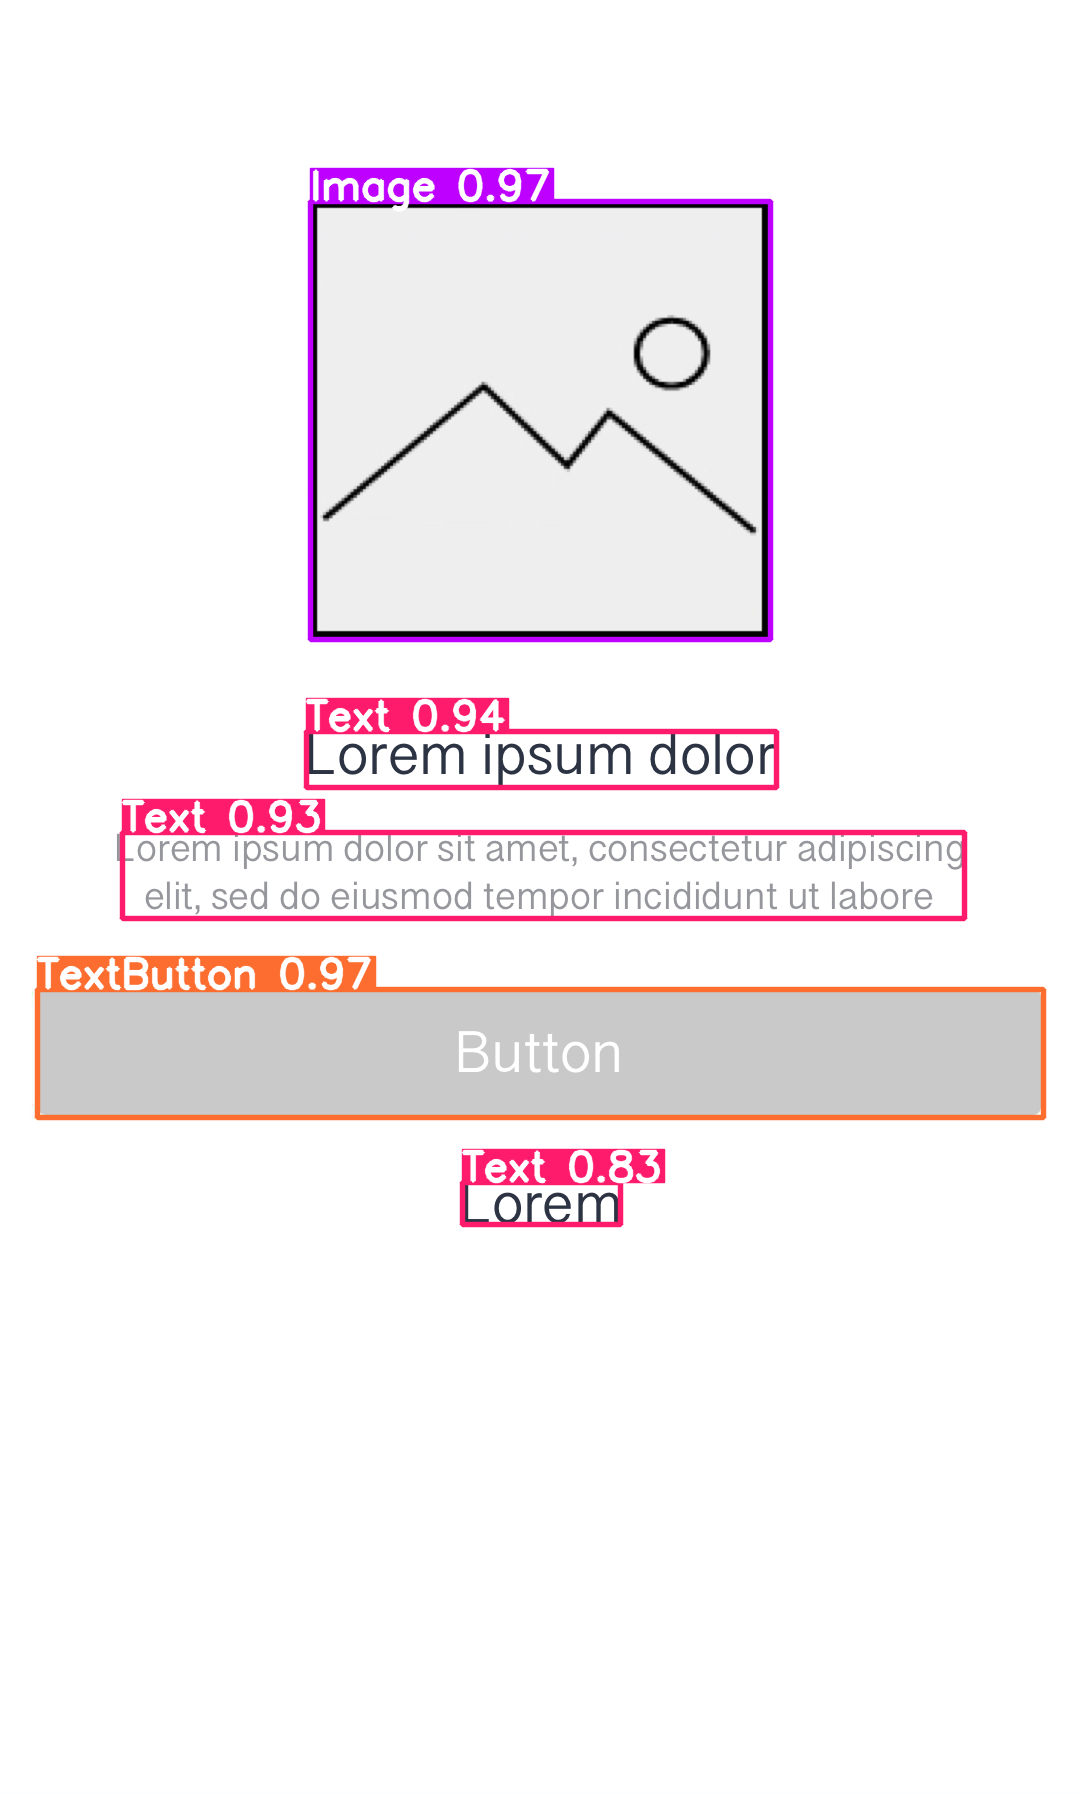

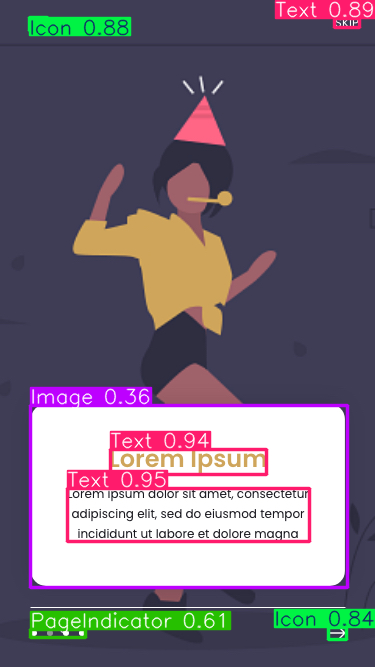

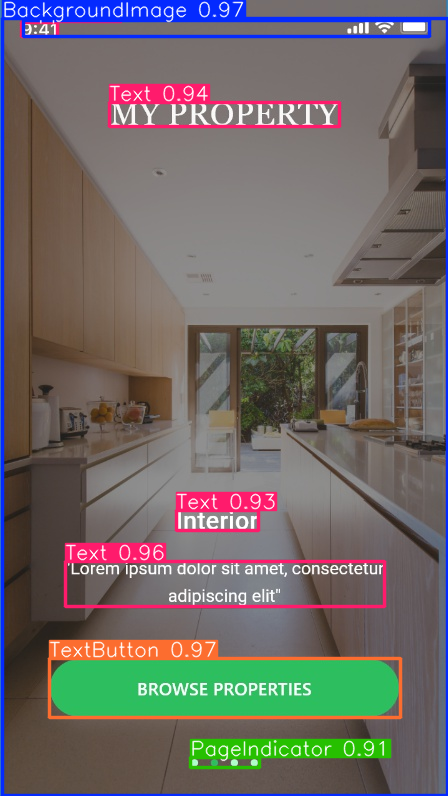

In [9]:
import random
for r in random.sample(results, 3):
    r.show()

In [32]:
import cv2
import numpy as np

# 클래스별 색상, 모서리 출력 기준 설정
STYLE_CAPABILITY = {
    "BackgroundImage":   {"color": True, "edge": False},
    "Bottom_Navigation": {"color": True, "edge": True},
    "Card":              {"color": True, "edge": True},
    "CheckBox":          {"color": True, "edge": True},
    "Checkbox":          {"color": True, "edge": True},
    "CheckedTextView":   {"color": True, "edge": True},
    "Drawer":            {"color": True, "edge": False},
    "EditText":          {"color": True, "edge": True},
    "Icon":              {"color": True, "edge": True},
    "Image":             {"color": True, "edge": True},
    "Map":               {"color": False, "edge": False},
    "Modal":             {"color": True, "edge": True},
    "Multi_Tab":         {"color": True, "edge": True},
    "PageIndicator":     {"color": True, "edge": True},
    "Remember":          {"color": True, "edge": False},
    "Spinner":           {"color": True, "edge": True},
    "Switch":            {"color": True, "edge": True},
    "Text":              {"color": True, "edge": False},
    "TextButton":        {"color": True, "edge": True},
    "Toolbar":           {"color": True, "edge": True},
    "UpperTaskBar":      {"color": True, "edge": True},
    "Button":            {"color": True, "edge": True}
}

# 색상 이름 출력 기준 설정
def ui_color(bgr):
    hsv = cv2.cvtColor(np.uint8([[bgr]]), cv2.COLOR_BGR2HSV)[0][0]
    h, s, v = hsv
    
    if s < 30 and v > 200:
        return "White"
    elif v < 50:
        return "Black"
    elif s < 30:
        return "Gray"

    if (176 <= h <= 179) or (0 <= h <= 3):
        return "Red"
    elif 4 <= h <= 11:
        return "Red-Orange"
    elif 12 <= h <= 18:
        return "Orange"
    elif 19 <= h <= 25:
        return "Orange-Yellow"
    elif 26 <= h <= 33:
        return "Yellow"
    elif 34 <= h <= 40:
        return "Yellow-Chartreuse"
    elif 41 <= h <= 48:
        return "Chartreuse"
    elif 49 <= h <= 55:
        return "Chartreuse-Green"
    elif 56 <= h <= 63:
        return "Green"
    elif 64 <= h <= 70:
        return "Spring Green"
    elif 71 <= h <= 78:
        return "Spring Green-Cyan"
    elif 79 <= h <= 85:
        return "Cyan"
    elif 86 <= h <= 93:
        return "Cyan-Azur"
    elif 94 <= h <= 100:
        return "Azure"
    elif 101 <= h <= 108:
        return "Azure-Blue"
    elif 109 <= h <= 115:
        return "Blue"
    elif 116 <= h <= 123:
        return "Blue-Violet"
    elif 124 <= h <= 130:
        return "Violet"
    elif 131 <= h <= 138:
        return "Violet-Magenta"
    elif 139 <= h <= 145:
        return "Magenta"
    elif 146 <= h <= 153:
        return "Magenta-Rose"
    elif 154 <= h <= 160:
        return "Rose"
    elif 161 <= h <= 168:
        return "Rose-Red"
    elif 169 <= h <= 175:
        return "Red"
    else:
        return "Unknown"

# 모서리 sharp, curve 판단
def ui_contour(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        epsilon = 0.05 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)

        # 꼭짓점 수가 많으면 curve로 간주
        if len(approx) > 6:
            return True

    # 대부분 직선이면 sharp로 간주
    return False


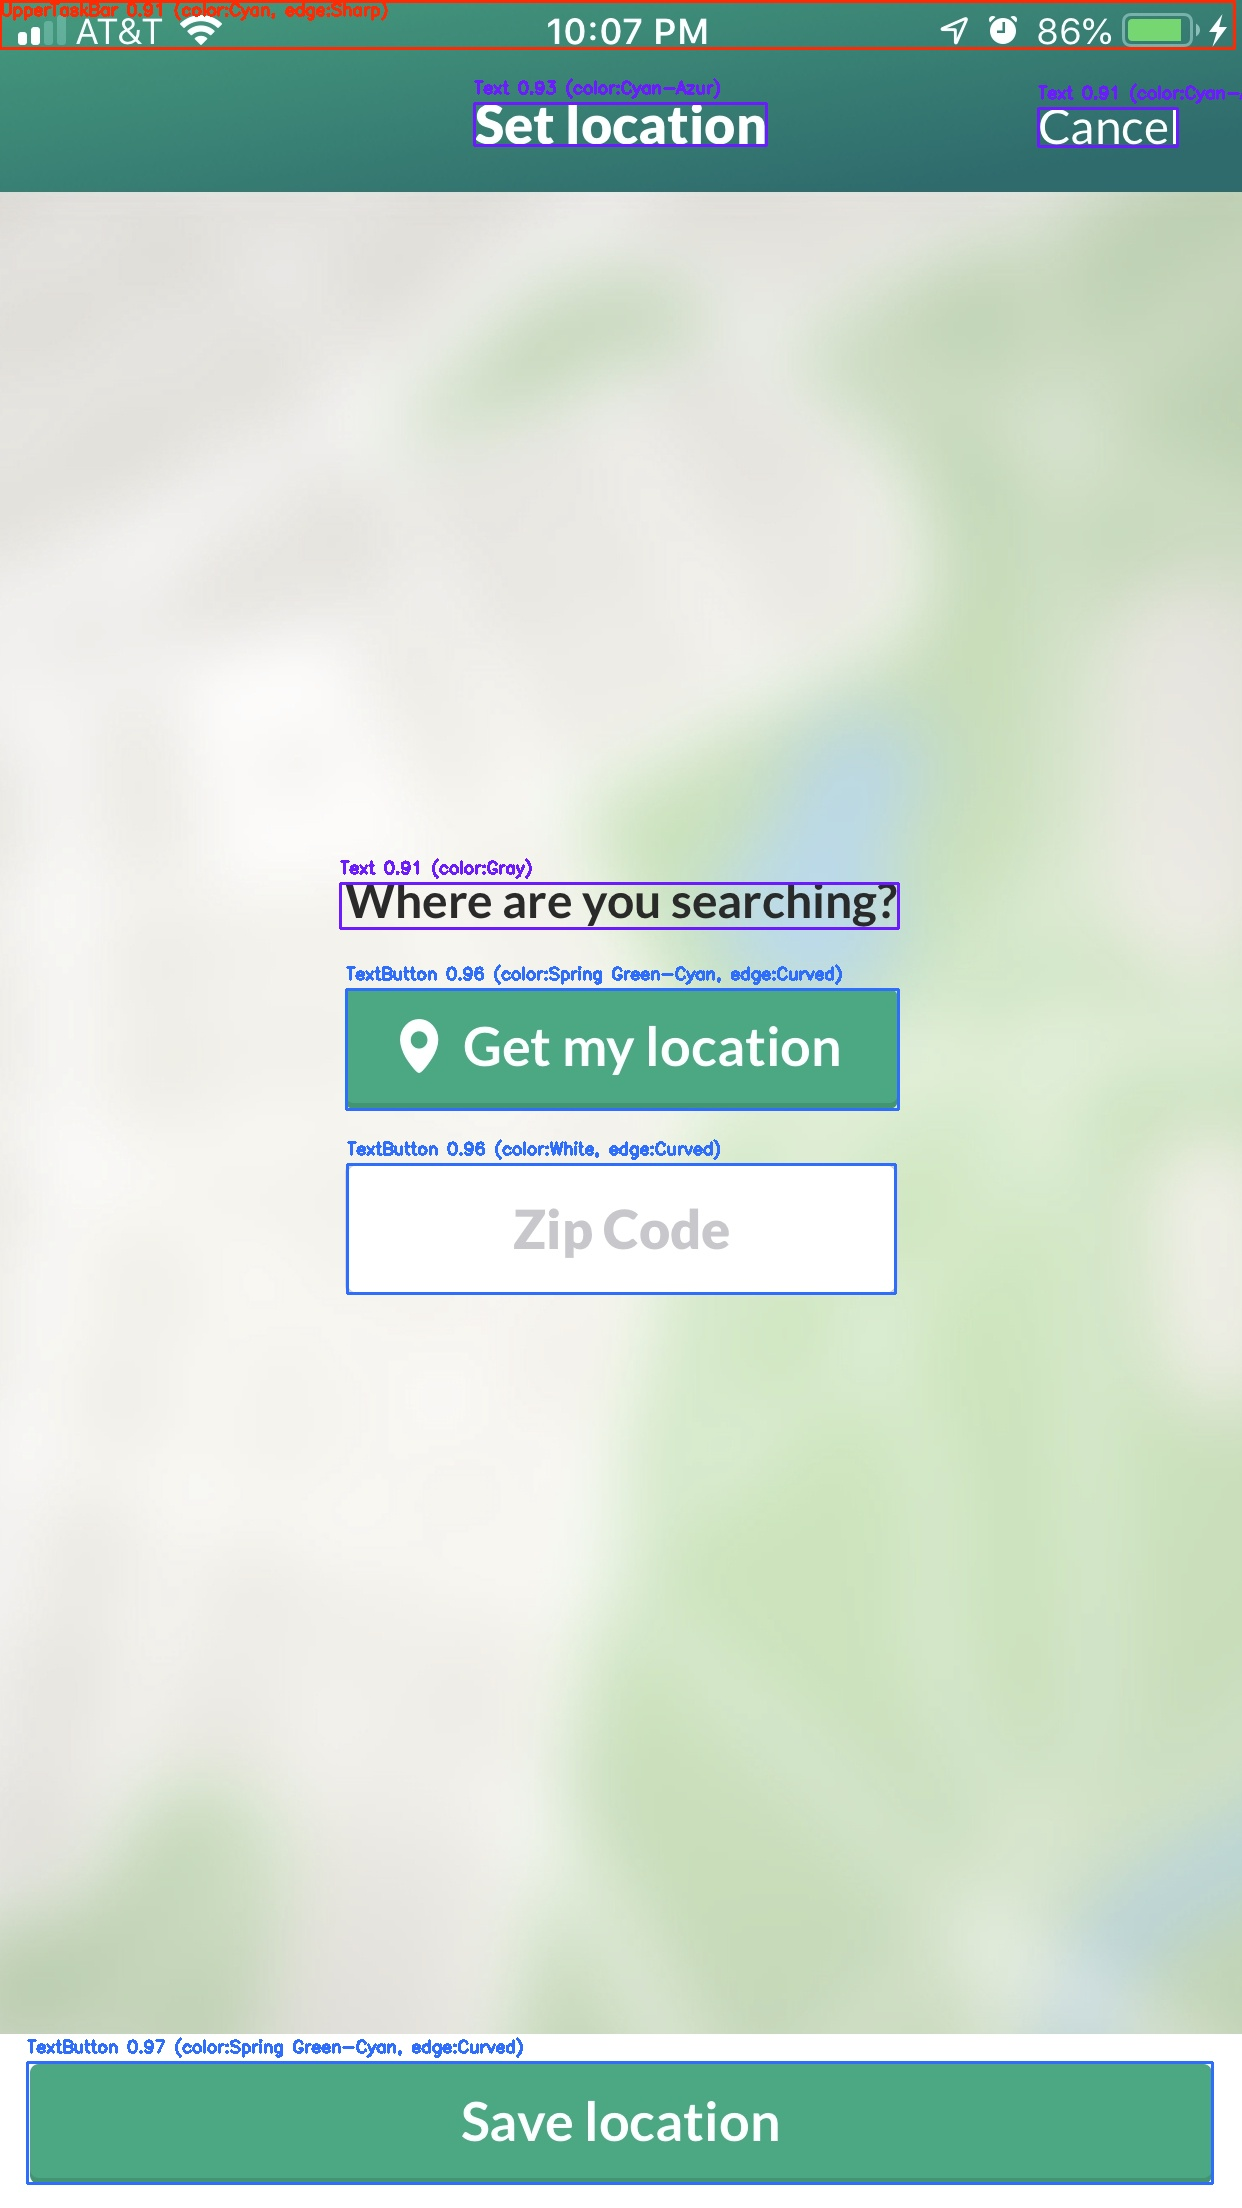

In [48]:
from ultralytics.utils.plotting import Colors
colors = Colors()

# 이미지 1장 랜덤하게 출력
for r in random.sample(results, 1):
    image = r.orig_img.copy()

    for bbox in r.boxes:
        cls_id = int(bbox.cls[0])
        cls_name = model.names[cls_id]

        # 바운딩 박스 좌표
        x1, y1, x2, y2 = map(int, bbox.xyxy[0])
        crop = image[y1:y2, x1:x2]

        # 객체 라벨에 추가할 스타일 정보 초기화
        info = STYLE_CAPABILITY.get(cls_name, {"color" : False, "edge": False})
        parts = [f"{cls_name} {bbox.conf[0]:.2f}"]

        # 색상 분석
        if info["color"]:
            avg_color = crop.mean(axis=(0, 1)).astype(np.uint8)
            parts.append(f"color:{ui_color(avg_color)}")

        # 모서리 분석
        if info["edge"]:
            edge = "Curved" if ui_contour(crop) else "Sharp"
            parts.append(f"edge:{edge}")

        # 객체 탐지, 색상, 모서리 포함 라벨 생성
        label = "(" + ", ".join(parts[1:]) + ")" if len(parts) > 1 else "" 
        label = f"{parts[0]} {label}".strip()

        # 시각화
        box_color = colors(cls_id)
        cv2.rectangle(image, (x1, y1), (x2, y2), box_color, 2)
        cv2.putText(image, label, (x1, max(y1 - 10, 15)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, box_color, 2)

# 이미지 출력
from PIL import Image
from IPython.display import display

cv2.imwrite("ui_result.jpg", image)
display(Image.open("ui_result.jpg"))
